### Approximating the integral

It is easy to see that as we use large $n$ (i.e., more qubits) and thus larger $b_{\mbox{max}}$, we can approximate the integral better as illustrated below. 

In [9]:
import math

b_max = math.pi / 1000  # upper limit of integral # 5
nbit = 10  # change this value to get discretized result closer to analytical results # 3

analyticResult = (b_max / 2.0 - math.sin(2 * b_max) / 4.0 ) / b_max  # the target integral can be analytically solved
print("Analytical Result:", analyticResult)

ndiv = 2**nbit  #number of discretization 
discretizedResult = 0.0
for i in range(ndiv):
    discretizedResult += math.sin(b_max / ndiv * (i + 0.5))**2
discretizedResult = discretizedResult / ndiv
print("Discretized Result:", discretizedResult)

Analytical Result: 3.289861639787202e-06
Discretized Result: 3.289860855402632e-06


In [11]:
import sys
sys.path.append('../libmitigation')

In [12]:
#Preparing qiskit environment
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import IBMQ
from qiskit import Aer
from scipy import optimize
import sys, time
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(10)

In [13]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import depolarizing_error
import qiskit.ignis.mitigation as mit
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter
import importlib
from inv_sgs import InvSGS
from inv_s_sgs import InvSSGS
from inv_lm_sgs import InvLMSGS
from inv_s_lm_sgs import InvSLMSGS
from inv_s_lm0_sgs import InvSLM0SGS
from sgs_algorithm import sgs_algorithm
from lib_grover import *

For example, quantum circuit with two Grover operators is shown below.

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/visualization/matplotlib.py:291: DeprecationWarning: style option/s (usepiformat, cregbundle, compress) is/are not supported
  set_style(current_style, style)


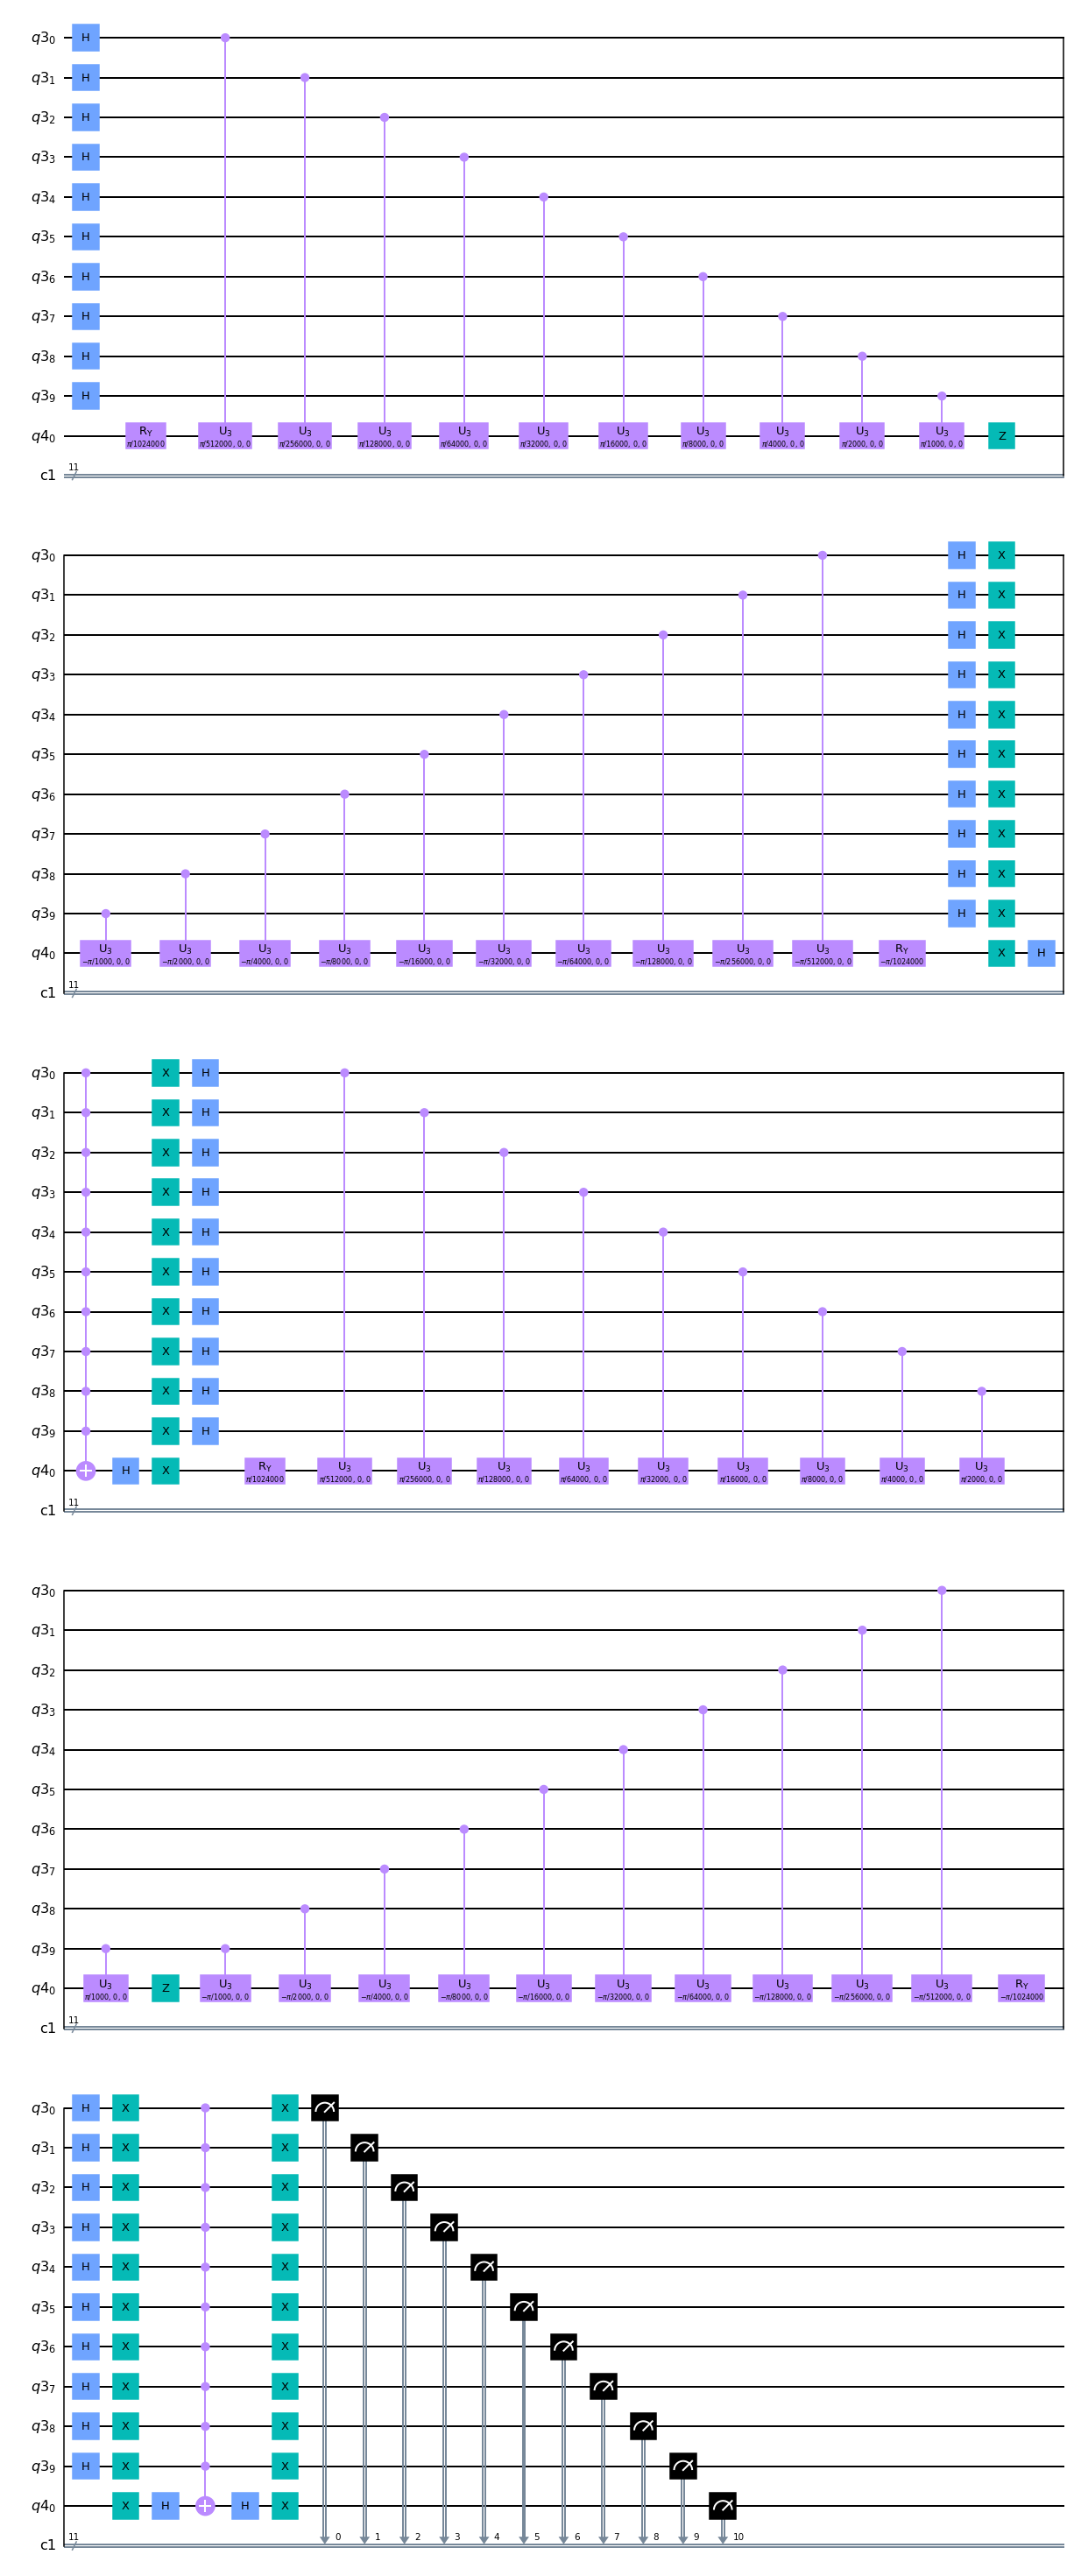

In [16]:
qc_list = create_grover_circuit([1], nbit, b_max)
my_style = {'usepiformat': True, 'cregbundle': True,'compress': True }
qc_list[0].draw(output="mpl", style=my_style, plot_barriers=False )

## Testing the algorithm with simulators

Let us run the algorithm with simulators

In [19]:
#setting the number of shots and Grover operators.

number_grover_list = [0, 1, 2, 4, 8, 16, 32, 64, 128]  # list of number of Grover operators
# number_grover_list = [i for i in range(100)]
shots_list = [100] * len(number_grover_list) # list of number of shots
if len(shots_list) != len(number_grover_list):
    raise Exception(
        'The length of shots_list should be equal to the length of number_grover_list.'
    )

backend = Aer.get_backend('qasm_simulator')

In [20]:
noise_model = NoiseModel()
for qi in range(nbit+1):
    if qi >= 0:
        read_err = ReadoutError([[0.97, 0.03],[0.03,0.97]])
        noise_model.add_readout_error(read_err, [qi])

Finally, we can run the algorithm as below: 

In [21]:
qc_list = create_grover_circuit(number_grover_list, nbit,b_max)  # list of Grover circuits

In [22]:
counts_list = run_grover(qc_list, number_grover_list, shots_list, backend, noise_model=noise_model)  # list of number of grover operators

0 th round with 0 oracles
0.456571102142334 s
1 th round with 1 oracles
0.014410972595214844 s
2 th round with 2 oracles
0.021297931671142578 s
3 th round with 3 oracles
0.027103900909423828 s
4 th round with 4 oracles
0.035223960876464844 s
5 th round with 5 oracles
0.038458824157714844 s
6 th round with 6 oracles
0.05034494400024414 s
7 th round with 7 oracles
0.06387519836425781 s
8 th round with 8 oracles
0.05994820594787598 s
9 th round with 9 oracles
0.0747530460357666 s
10 th round with 10 oracles
0.07269406318664551 s
11 th round with 11 oracles
0.08775711059570312 s
12 th round with 12 oracles
0.0967707633972168 s
13 th round with 13 oracles
0.09959292411804199 s
14 th round with 14 oracles
0.09163117408752441 s
15 th round with 15 oracles
0.09800219535827637 s
16 th round with 16 oracles
0.1115272045135498 s
17 th round with 17 oracles
0.12214088439941406 s
18 th round with 18 oracles
0.12605786323547363 s
19 th round with 19 oracles
0.18078994750976562 s
20 th round with 20 

In [23]:
import pickle
with open("raw_result_p003_q003_piover1000.pkl", "wb") as f:
    pickle.dump(counts_list, f)

In [24]:
import pickle
with open("raw_result_p003_q003_piover1000.pkl", "rb") as f:
    counts_list = pickle.load(f)

In [25]:
hit_list = make_hit_list(counts_list)
print(hit_list)

[64, 72, 62, 73, 76, 69, 67, 74, 71, 68, 71, 77, 70, 64, 74, 74, 76, 69, 69, 71, 76, 62, 67, 70, 63, 71, 79, 76, 68, 76, 73, 68, 75, 70, 68, 71, 72, 79, 76, 65, 67, 74, 59, 72, 62, 67, 66, 64, 65, 77, 66, 65, 71, 74, 70, 64, 68, 66, 64, 69, 76, 71, 65, 67, 67, 67, 77, 65, 58, 66, 71, 62, 67, 69, 59, 67, 69, 68, 61, 64, 74, 66, 66, 73, 69, 72, 62, 64, 68, 66, 77, 64, 64, 70, 56, 62, 65, 64, 65, 55]


## Mitigation

In [27]:
shots = 8192
qr = QuantumRegister(nbit+1)
mit_pattern = [[i] for i in range(nbit+1)]
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
job = execute(meas_calibs, backend=Aer.get_backend('qasm_simulator'), shots=shots, noise_model=noise_model)
cal_results = job.result()
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)

In [28]:
meas_filter = InvSGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
mit_counts_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    mit_counts_list.append(x_tilde)
mit_hit_list = make_hit_list(mit_counts_list)

strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000018
number of positive values:  1025
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999956
number of positive values:  1018
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000009
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999992
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000004
number of positive values:  1023
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000009
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.000000000000002
number of positive values:  1024
main process: Done!
strict 

sum of mitigated probability vector x: 0.999999999999997
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000002
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999993
number of positive values:  1023
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999971
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000013
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.999999999999999
number of positive values:  1021
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999983
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of m

In [29]:
meas_filter = InvSSGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_S_list = [] # K = 0
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    x_tilde_S_list.append(x_tilde)
mit_hit_S_list = make_hit_list(x_tilde_S_list)
print(mit_hit_S_list)

Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.1372433430126492
number of positive values:  14
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.0548978378973992
number of positive values:  6
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.0928137609310107
number of positive values:  15
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.049442927502237
number of positive values:  8
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.0380298011406124
number of positive values:  8
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.0960974299067667
number of positive values:  8
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_

sum of mitigated probability vector x_s: 1.0651525352199311
number of positive values:  12
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.072917692953718
number of positive values:  14
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.0771641545867567
number of positive values:  16
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.1432940115602608
number of positive values:  11
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.1320131055404874
number of positive values:  10
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.1124861533290045
number of positive values:  13
main process: Done!
Restriction to labels of y + SGS algorithm
sum of mitigated probability vector x_s: 1.1566845030846649
number of positiv

In [30]:
meas_filter = InvSLM0SGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_S_lm_0_list = [] # K = 0
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    x_tilde_S_lm_0_list.append(x_tilde)
mit_hit_S_lm_0_list = make_hit_list(x_tilde_S_lm_0_list)
print(mit_hit_S_lm_0_list)

Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.1372433430126492
sum of mitigated probability vector x_hat_s: 1.1373474055209787
number of positive values:  14
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0548978378973992
sum of mitigated probability vector x_hat_s: 1.0549961190536996
number of positive values:  6
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0928137609310107
sum of mitigated probability vector x_hat_s: 1.0929204352545803
number of positive values:  15
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.049442927502237
sum of mitigated probability vector x_hat_s: 1.0495465330753655
number of positive values:  8
main process: Done!
Restriction to labels of y + Lagrange Multi

sum of mitigated probability vector x_hat_s: 1.09759357580608
number of positive values:  11
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0884106491220096
sum of mitigated probability vector x_hat_s: 1.0884990520504303
number of positive values:  8
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0514570716351985
sum of mitigated probability vector x_hat_s: 1.0515680380057555
number of positive values:  8
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.087938979158689
sum of mitigated probability vector x_hat_s: 1.0880320768622738
number of positive values:  5
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0966082000365889
sum of mitigated probability vector x_hat_s: 1

sum of mitigated probability vector x_s: 1.1093529346989117
sum of mitigated probability vector x_hat_s: 1.1094721218859733
number of positive values:  15
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.1192825066414775
sum of mitigated probability vector x_hat_s: 1.1194016927528274
number of positive values:  13
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.144268702081851
sum of mitigated probability vector x_hat_s: 1.1443573806180025
number of positive values:  10
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0974744006421342
sum of mitigated probability vector x_hat_s: 1.097578549704457
number of positive values:  13
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1

In [31]:
import pickle
with open("hit_list_p003_q003_piover1000.pkl", "wb") as f:
    pickle.dump(hit_list, f)

In [32]:
import pickle
with open("mit_hit_list_p003_q003_piover1000.pkl", "wb")as f:
    pickle.dump(mit_hit_list, f)

In [33]:
import pickle
with open("mit_hit_S_list_p003_q003_piover1000.pkl", "wb")as f:
    pickle.dump(mit_hit_S_list, f)

In [34]:
import pickle
with open("mit_hit_S_lm_0_list_p003_q003_piover1000.pkl", "wb")as f:
    pickle.dump(mit_hit_S_lm_0_list, f)

Text(0, 0.5, 'number of shots for $|00...0>$')

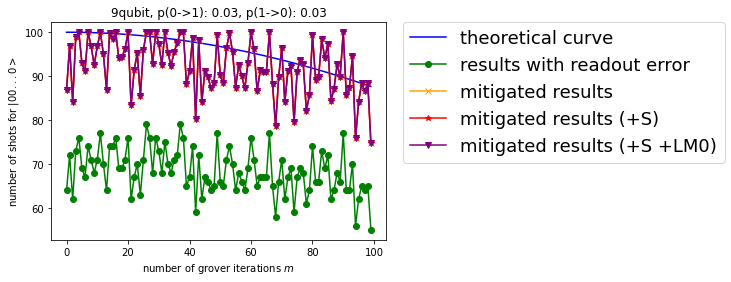

In [44]:
divide = 100
# plt.plot(np.linspace(0,number_grover_list[-1], divide), 100 * np.cos(2 * np.linspace(0,number_grover_list[-1], divide) * np.arccos(np.sqrt(discretizedResult))) ** 2, label="theoretical curve", color="blue")
plt.plot(number_grover_list, 100 * np.cos(2 * np.array(number_grover_list) * np.arccos(np.sqrt(discretizedResult))) ** 2, label="theoretical curve", color="blue")
plt.plot(number_grover_list, hit_list, marker="o", label="results with readout error", color="green")
plt.plot(number_grover_list, mit_hit_list, marker="x", label="mitigated results", color="orange")
plt.plot(number_grover_list, mit_hit_S_list, marker="*", label="mitigated results (+S)", color="red")
plt.plot(number_grover_list, mit_hit_S_lm_0_list, marker="v", label="mitigated results (+S +LM0)", color="purple")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.title("9qubit, p(0->1): 0.03, p(1->0): 0.03")
plt.xlabel("number of grover iterations $m$")
plt.ylabel("number of shots for $|00...0>$")

## Post-processing

In [38]:
sin_hit_list = [100 - h for h in hit_list]
sin_mit_hit_list = [100 - h for h in mit_hit_list]
sin_mit_hit_S_list = [100 - h for h in mit_hit_S_list]
sin_mit_hit_S_lm_0_list = [100 - h for h in mit_hit_S_lm_0_list]

In [39]:
thetaCandidate_list = calculate_theta(
    sin_hit_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_list = calculate_theta(
    sin_mit_hit_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_S_list = calculate_theta(
    sin_mit_hit_S_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_S_lm_0_list = calculate_theta(
    sin_mit_hit_S_lm_0_list, number_grover_list, shots_list)  # list of estimated theta values

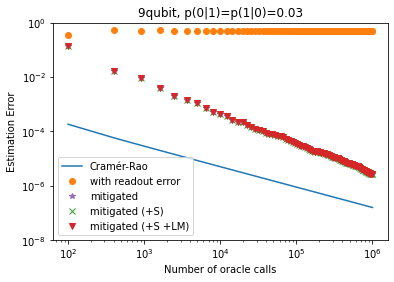

In [40]:
error_list = np.abs(np.sin(thetaCandidate_list)**2 - discretizedResult)  # list of estimation errors
error_mit_list = np.abs(np.sin(thetaCandidate_mit_list)**2 - discretizedResult)  # list of estimation errors
error_mit_S_list = np.abs(np.sin(thetaCandidate_mit_S_list)**2 - discretizedResult)  # list of estimation errors
error_mit_S_lm_0_list = np.abs(np.sin(thetaCandidate_mit_S_lm_0_list)**2 - discretizedResult)  # list of estimation errors
OracleCall_list = []  # list of number of oracle calls
ErrorCramérRao_list = []  # list of Cramér-Rao lower bound
for i in range(len(number_grover_list)):
    OracleCall_list.append(
        CalcNumberOracleCalls(i, shots_list, number_grover_list))
    ErrorCramérRao_list.append(
        CalcErrorCramérRao(i, shots_list, discretizedResult, number_grover_list))

In [ ]:
p = plt.plot( OracleCall_list, ErrorCramérRao_list)
p0 = plt.plot( OracleCall_list, error_list, 'o')
p1 = plt.plot( OracleCall_list, error_mit_list, '*', color='C4')
p2 = plt.plot( OracleCall_list, error_mit_S_list, 'x', color='C2')
p3 = plt.plot( OracleCall_list, error_mit_S_lm_0_list, 'v', color='C3')

plt.title("9qubit, p(0|1)=p(1|0)=0.03, b_max=π/1000")
plt.xscale('log')
plt.xlabel("Number of oracle calls")
plt.yscale('log')
plt.ylim(0.00000001, 1)
plt.ylabel("Estimation Error")
plt.legend((p[0], p0[0], p1[0], p2[0], p3[0]), ("Cramér-Rao", "with readout error", "mitigated", "mitigated (+S)", "mitigated (+S +LM)"))
plt.show()

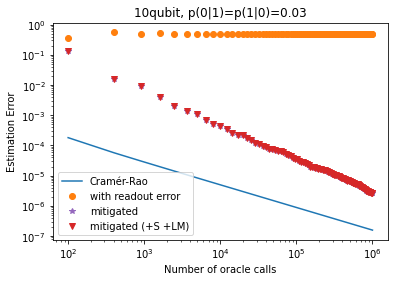

In [41]:
plt.clf()
p = plt.plot( OracleCall_list, ErrorCramérRao_list)
p0 = plt.plot( OracleCall_list, error_list, 'o')
p1 = plt.plot( OracleCall_list, error_mit_list, '*', color='C4')
# p2 = plt.plot( OracleCall_list, error_mit_S_list, 'x', color='C2')
p3 = plt.plot( OracleCall_list, error_mit_S_lm_0_list, 'v', color='C3')

plt.title("10qubit, p(0|1)=p(1|0)=0.03, b_max=π/1000")
plt.xscale('log')
plt.xlabel("Number of oracle calls")
plt.yscale('log')
plt.ylabel("Estimation Error")
plt.legend((p[0], p0[0], p1[0], p3[0]), ("Cramér-Rao", "with readout error", "mitigated", "mitigated (+S +LM)"))
plt.show()

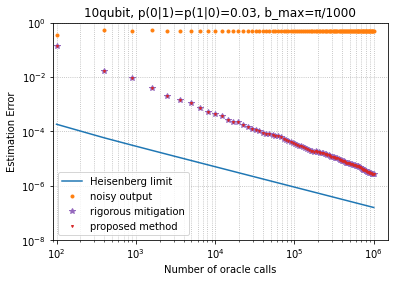

In [43]:
plt.clf()
p = plt.loglog( OracleCall_list, ErrorCramérRao_list)
p0 = plt.loglog( OracleCall_list, error_list, 'o', markersize=3)
p1 = plt.loglog( OracleCall_list, error_mit_list, '*', color='C4', markersize=6)
# p2 = plt.plot( OracleCall_list, error_mit_S_list, 'x', color='C2', markersize=4)
p3 = plt.loglog( OracleCall_list, error_mit_S_lm_0_list, 'v', color='C3', markersize=2)

plt.title("10qubit, p(0|1)=p(1|0)=0.03, b_max=π/1000")
plt.xlim(OracleCall_list[0]*0.9, OracleCall_list[-1]*1.5)
plt.xlabel("Number of oracle calls")
plt.ylim(0.00000001, 1)
plt.ylabel("Estimation Error")
plt.grid(True, which="both", ls="dotted")
plt.legend((p[0], p0[0], p1[0], p3[0]), ("Heisenberg limit", "noisy output", "rigorous mitigation", "proposed method"))
plt.show()